<a href="https://colab.research.google.com/github/iguchi-lab/jjj_CRAC/blob/master/CRAC_calc_200713_mitaka.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# セントラルエアコンディショナの一次エネルギー消費量計算

# Google Drive のマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# フォルダの設定

In [ ]:
import os
import sys
import numpy as np
import pandas as pd

In [ ]:
sys.path.append('/content/drive/My Drive/Colab Notebooks/全館暖冷房WG/')
%cd /content/drive/My Drive/Colab Notebooks/全館暖冷房WG/
%pwd

/content/drive/My Drive/Colab Notebooks/全館暖冷房WG


'/content/drive/My Drive/Colab Notebooks/全館暖冷房WG'

In [ ]:
!pip install japanize-matplotlib                                                        
import japanize_matplotlib                                                              #日本語化matplotlibをimport     グラフ描画
import matplotlib.pyplot as plt                                                         #matplotlib.pyplotをimport      グラフ描画
import matplotlib.dates as mdates                                                       #matplotlib.pyplotをimport      グラフ描画
import matplotlib as mpl                                                                #matplotlibをimport             グラフ描画

from datetime import datetime, timedelta                                                #日付

# section4-CRAC.py

In [ ]:
# ダクト式セントラル空調機
import pyhees.section4_2 as dc
import pyhees.section4_2_a as dc_a
import pyhees.section4_2_b as dc_spec

# エアーコンディショナー
import pyhees.section4_3 as rac
import pyhees.section4_3_a as rac_spec

#床下
import pyhees.section3_1_e as uf

from functools import lru_cache

import datetime

import pyhees.section3_1 as ld

from pyhees.section3_2_8 import \
    get_r_env

from pyhees.section11_1 import \
    load_outdoor, \
    get_T_ex, \
    get_Theta_ex, \
    get_X_ex, \
    calc_h_ex, \
    load_climate, \
    get_J

from pyhees.section3_1 import \
    get_A_NR

from pyhees.section4_7_i import \
    get_A_A_R

from pyhees.section11_3 import \
    load_schedule, \
    get_schedule_ac

In [ ]:
# 日付dの時刻tにおける1時間当たりの暖房時の消費電力量（kWh/h）(1)
def calc_CRAC_E_E_H_d_t(Theta_hs_out_d_t, Theta_hs_in_d_t, V_hs_supply_d_t, V_hs_vent_d_t, C_df_H_d_t,
           V_hs_dsgn_H, P_fan_rtd_H, region, q_rtd_C, q_rtd_H, e_rtd_H):

    df_output = pd.DataFrame(index =pd.date_range('2019-01-01 01:00:00', '2020-01-01 00:00:00', freq='h'))

    # (3)
    q_hs_H_d_t = dc_a.get_q_hs_H_d_t(Theta_hs_out_d_t, Theta_hs_in_d_t, V_hs_supply_d_t, C_df_H_d_t, region)

    E_E_CRAC_H_d_t = rac.calc_E_E_H_d_t(region, q_rtd_C, q_rtd_H, e_rtd_H, False, q_hs_H_d_t * 3.6 / 1000)

    # (37)
    E_E_fan_H_d_t = dc_a.get_E_E_fan_H_d_t(P_fan_rtd_H, V_hs_vent_d_t, V_hs_supply_d_t, V_hs_dsgn_H, q_hs_H_d_t * 3.6 / 1000)

    df_output['q_hs_H_d_t'] = q_hs_H_d_t
    df_output['E_E_CRAC_H_d_t'] = E_E_CRAC_H_d_t
    df_output['E_E_fan_H_d_t'] = E_E_fan_H_d_t

    # (1)
    E_E_H_d_t = E_E_CRAC_H_d_t + E_E_fan_H_d_t

    print('【calc_CRAC_E_E_H_d_t】')

    fig=plt.figure(facecolor = 'w', figsize = (15, 2))
    ax = fig.add_subplot(1, 1, 1)                                   
    ax.plot(pd.date_range('2019-01-01 01:00:00', '2020-01-01 00:00:00', freq='h'), q_hs_H_d_t, linewidth = 0.5)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax.set_ylabel('1時間当たりの熱源機の平均暖房能力 (W)')                                                                           
    ax.set_ylim(0, 8000)
    plt.show() 

    fig=plt.figure(facecolor = 'w',figsize = (15, 2))
    ax = fig.add_subplot(1, 1, 1)                                   
    ax.plot(pd.date_range('2019-01-01 01:00:00', '2020-01-01 00:00:00', freq='h'), E_E_CRAC_H_d_t, linewidth = 0.5)
    ax.plot(pd.date_range('2019-01-01 01:00:00', '2020-01-01 00:00:00', freq='h'), E_E_fan_H_d_t, linewidth = 0.5)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax.set_ylabel('消費電力量　（kWh/h）')                                                                           
    ax.set_ylim(0, 5)
    plt.show() 

    df_output.to_csv('/content/drive/My Drive/Colab Notebooks/全館暖冷房WG/output_CRAC_heating.csv')
    return E_E_H_d_t

In [ ]:
def get_q_hs_C_d_t_2(Theta_hs_out_d_t, Theta_hs_in_d_t, X_hs_out_d_t, X_hs_in_d_t,V_hs_supply_d_t, region):
    """(4a-1)(4b-1)(4c-1)(4a-2)(4b-2)(4c-2)(4a-3)(4b-3)(4c-3)

    :param Theta_hs_out_d_t:日付dの時刻tにおける熱源機の出口における空気温度（℃）
    :param Theta_hs_in_d_t:日付dの時刻tにおける熱源機の入口における空気温度（℃）
    :param X_hs_out_d_t:日付dの時刻tにおける熱源機の出口における絶対湿度（kg/kg(DA)）
    :param X_hs_in_d_t:日付dの時刻tにおける熱源機の入口における絶対湿度（kg/kg(DA)）
    :param V_hs_supply_d_t:日付dの時刻tにおける熱源機の風量（m3/h）
    :param region:地域区分
    :return:日付dの時刻tにおける1時間当たりの熱源機の平均冷房能力（-）
    """
    H, C, M = dc_a.get_season_array_d_t(region)
    c_p_air = dc_a.get_c_p_air()
    rho_air = dc_a.get_rho_air()
    L_wtr = dc_a.get_L_wtr()

    # 暖房期および中間期 (4a-1)(4b-1)(4c-1)(4a-3)(4b-3)(4c-3)
    q_hs_C_d_t = np.zeros(24 * 365)
    q_hs_CS_d_t = np.zeros(24 * 365)
    q_hs_CL_d_t = np.zeros(24 * 365)

    # 冷房期 (4a-2)(4b-2)(4c-2)
    q_hs_CS_d_t[C] = np.clip(c_p_air * rho_air * (Theta_hs_in_d_t[C] - Theta_hs_out_d_t[C]) * (V_hs_supply_d_t[C] / 3600), 0, None)

    Cf = np.logical_and(C, q_hs_CS_d_t > 0)

    q_hs_CL_d_t[Cf] = np.clip(L_wtr * rho_air * (X_hs_in_d_t[Cf] - X_hs_out_d_t[Cf]) * (V_hs_supply_d_t[Cf] / 3600) * 10 ** 3, 0, None)

    return  q_hs_CS_d_t, q_hs_CL_d_t

In [ ]:
def get_CRAC_E_E_C_d_t(Theta_hs_out_d_t, Theta_hs_in_d_t,  X_hs_out_d_t, X_hs_in_d_t, V_hs_supply_d_t, V_hs_vent_d_t,
                  q_rtd_C, e_rtd_C, V_hs_dsgn_C, P_fan_rtd_C, region):

    df_output = pd.DataFrame(index =pd.date_range('2019-01-01 01:00:00', '2020-01-01 00:00:00', freq='h'))

    # 外気条件
    #outdoor = load_outdoor()
    outdoor = pd.read_csv('samples/outdoor_mitaka.csv', skiprows=4, nrows=24 * 365, names=(
    'day', 'hour', 'holiday', 'Theta_ex_1', 'X_ex_1'))

    #Theta_ex_d_t = get_Theta_ex(region, outdoor)
    Theta_ex_d_t = outdoor['Theta_ex_1'].values

    # (4)
    q_hs_CS_d_t, q_hs_CL_d_t = get_q_hs_C_d_t_2(Theta_hs_out_d_t, Theta_hs_in_d_t, X_hs_out_d_t, X_hs_in_d_t, V_hs_supply_d_t, region)

    E_E_CRAC_C_d_t = rac.calc_E_E_C_d_t(region, q_rtd_C, e_rtd_C, False, q_hs_CS_d_t * 3.6 / 1000, q_hs_CL_d_t * 3.6 / 1000)

    # (38)
    E_E_fan_C_d_t = dc_a.get_E_E_fan_C_d_t(P_fan_rtd_C, V_hs_vent_d_t, V_hs_supply_d_t, V_hs_dsgn_C, q_hs_CS_d_t * 3.6 / 1000 + q_hs_CL_d_t * 3.6 / 1000)

    df_output['q_hs_CS_d_t'] = q_hs_CS_d_t
    df_output['q_hs_CL_d_t'] = q_hs_CL_d_t
    df_output['E_E_CRAC_C_d_t'] = E_E_CRAC_C_d_t
    df_output['E_E_fan_C_d_t'] = E_E_fan_C_d_t

    # (2)
    E_E_C_d_t = E_E_CRAC_C_d_t + E_E_fan_C_d_t

    print('【get_CRAC_E_E_C_d_t】')

    fig=plt.figure(facecolor = 'w', figsize = (15, 2))
    ax = fig.add_subplot(1, 1, 1)                                   
    ax.plot(pd.date_range('2019-01-01 01:00:00', '2020-01-01 00:00:00', freq='h'), q_hs_CS_d_t, linewidth = 0.5)
    ax.plot(pd.date_range('2019-01-01 01:00:00', '2020-01-01 00:00:00', freq='h'), q_hs_CL_d_t, linewidth = 0.5)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax.set_ylabel('1時間当たりの熱源機の平均冷房能力 (W)')                                                                           
    ax.set_ylim(0, 8000)
    plt.show() 

    fig=plt.figure(facecolor = 'w',figsize = (15, 2))
    ax = fig.add_subplot(1, 1, 1)                                   
    ax.plot(pd.date_range('2019-01-01 01:00:00', '2020-01-01 00:00:00', freq='h'), E_E_CRAC_C_d_t, linewidth = 0.5)
    ax.plot(pd.date_range('2019-01-01 01:00:00', '2020-01-01 00:00:00', freq='h'), E_E_fan_C_d_t, linewidth = 0.5)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax.set_ylabel('消費電力量　（kWh/h）')                                                                           
    ax.set_ylim(0, 5)
    plt.show() 

    df_output.to_csv('/content/drive/My Drive/Colab Notebooks/全館暖冷房WG/output_CRAC_cooling.csv')

    return E_E_C_d_t

In [ ]:
# 未処理負荷と機器の計算に必要な変数を取得
def calc_CRAC_Q_UT_A(A_A, A_MR, A_OR, A_env, mu_H, mu_C, q_rtd_C, q_rtd_H, q_max_C, q_max_H, V_hs_dsgn_H, V_hs_dsgn_C, Q,
             VAV, general_ventilation, duct_insulation, region, L_H_d_t_i, L_CS_d_t_i, L_CL_d_t_i):

    df_output = pd.DataFrame(index =pd.date_range('2019-01-01 01:00:00', '2020-01-01 00:00:00', freq='h'))
    df_output2 = pd.DataFrame()

    # 外気条件
    #outdoor = load_outdoor()

    outdoor = pd.read_csv('samples/outdoor_mitaka.csv', skiprows=4, nrows=24 * 365, names=(
    'day', 'hour', 'holiday', 'Theta_ex_1', 'X_ex_1'))

    #Theta_ex_d_t = get_Theta_ex(region, outdoor)
    #X_ex_d_t = get_X_ex(region, outdoor)
    Theta_ex_d_t = outdoor['Theta_ex_1'].values
    X_ex_d_t = outdoor['X_ex_1'].values

    #climate = load_climate(region)
    climate = pd.read_csv('samples/climateData_6_mitaka.csv', nrows=24 * 365)
    
    #J_d_t = get_J(climate)
    J_d_t = climate["水平面天空日射量 [W/m2]"].values
    h_ex_d_t = calc_h_ex(X_ex_d_t, Theta_ex_d_t)


    df_output['Theta_ex_d_t'] = Theta_ex_d_t
    df_output['X_ex_d_t'] = X_ex_d_t
    df_output['J_d_t'] = J_d_t

    print('【calc_CRAC_Q_UT_A】')
    
    fig=plt.figure(facecolor = 'w', figsize = (15, 2))
    ax = fig.add_subplot(1, 1, 1)                                   
    ax.plot(pd.date_range('2019-01-01 01:00:00', '2020-01-01 00:00:00', freq='h'), Theta_ex_d_t, linewidth = 0.5)
    ax.plot(pd.date_range('2019-01-01 01:00:00', '2020-01-01 00:00:00', freq='h'), X_ex_d_t, linewidth = 0.5)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax.set_ylabel('温度（℃）、絶対湿度（g/kg）')                                                                           
    ax.set_ylim(-10, 40)
    plt.show() 

    fig=plt.figure(facecolor = 'w', figsize = (15, 2))
    ax = fig.add_subplot(1, 1, 1)                                   
    ax.plot(pd.date_range('2019-01-01 01:00:00', '2020-01-01 00:00:00', freq='h'), J_d_t, linewidth = 0.5)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax.set_ylabel('水平面全天日射量（W/m2）')                                                                           
    ax.set_ylim(0, 500)
    plt.show() 

    #主たる居室・その他居室・非居室の面積
    A_HCZ_i = np.array([ld.get_A_HCZ_i(i, A_A, A_MR, A_OR) for i in range(1, 6)])
    A_HCZ_R_i = [ld.get_A_HCZ_R_i(i) for i in range(1, 6)]
    A_NR = get_A_NR(A_A, A_MR, A_OR)

    df_output2['A_HCZ_i'] = A_HCZ_i
    df_output2['A_HCZ_R_i'] = A_HCZ_R_i
    df_output2['A_NR'] = A_NR

    # (67)  水の蒸発潜熱
    L_wtr = dc.get_L_wtr()
    df_output2['L_wtr'] = L_wtr

    # (66d)　非居室の在室人数
    n_p_NR_d_t = dc.calc_n_p_NR_d_t(A_NR)
    df_output['n_p_NR_d_t'] = n_p_NR_d_t

    # (66c)　その他居室の在室人数
    n_p_OR_d_t = dc.calc_n_p_OR_d_t(A_OR)
    df_output['n_p_OR_d_t'] = n_p_OR_d_t

    # (66b)　主たる居室の在室人数
    n_p_MR_d_t = dc.calc_n_p_MR_d_t(A_MR)
    df_output['n_p_MR_d_t'] = n_p_MR_d_t

    # (66a)　在室人数
    n_p_d_t = dc.get_n_p_d_t(n_p_MR_d_t, n_p_OR_d_t, n_p_NR_d_t)
    df_output['n_p_d_t'] = n_p_d_t

    # 人体発熱
    q_p_H = dc.get_q_p_H()
    q_p_CS = dc.get_q_p_CS()
    q_p_CL = dc.get_q_p_CL()
    df_output2['q_p_H'] = q_p_H
    df_output2['q_p_CS'] = q_p_CS
    df_output2['q_p_CL'] = q_p_CL

    # (65d)　非居室の内部発湿
    w_gen_NR_d_t = dc.calc_w_gen_NR_d_t(A_NR)
    df_output['w_gen_NR_d_t'] = w_gen_NR_d_t

    # (65c)　その他居室の内部発湿
    w_gen_OR_d_t = dc.calc_w_gen_OR_d_t(A_OR)
    df_output['w_gen_OR_d_t'] = w_gen_OR_d_t

    # (65b)　主たる居室の内部発湿
    w_gen_MR_d_t = dc.calc_w_gen_MR_d_t(A_MR)
    df_output['w_gen_MR_d_t'] = w_gen_MR_d_t

    # (65a)　内部発湿
    w_gen_d_t = dc.get_w_gen_d_t(w_gen_MR_d_t, w_gen_OR_d_t, w_gen_NR_d_t)
    df_output['w_gen_d_t'] = w_gen_d_t

    # (64d)　非居室の内部発熱
    q_gen_NR_d_t = dc.calc_q_gen_NR_d_t(A_NR)
    df_output['q_gen_NR_d_t'] = q_gen_NR_d_t

    # (64c)　その他居室の内部発熱
    q_gen_OR_d_t = dc.calc_q_gen_OR_d_t(A_OR)
    df_output['q_gen_OR_d_t'] = q_gen_OR_d_t

    # (64b)　主たる居室の内部発熱
    q_gen_MR_d_t = dc.calc_q_gen_MR_d_t(A_MR)
    df_output['q_gen_MR_d_t'] = q_gen_MR_d_t

    # (64a)　内部発熱
    q_gen_d_t = dc.get_q_gen_d_t(q_gen_MR_d_t, q_gen_OR_d_t, q_gen_NR_d_t)
    df_output['q_gen_d_t'] = q_gen_d_t

    # (63)　局所排気量
    V_vent_l_NR_d_t = dc.get_V_vent_l_NR_d_t()
    V_vent_l_OR_d_t = dc.get_V_vent_l_OR_d_t()
    V_vent_l_MR_d_t = dc.get_V_vent_l_MR_d_t()
    V_vent_l_d_t = dc.get_V_vent_l_d_t(V_vent_l_MR_d_t, V_vent_l_OR_d_t, V_vent_l_NR_d_t)

    df_output['V_vent_l_NR_d_t'] = V_vent_l_NR_d_t
    df_output['V_vent_l_OR_d_t'] = V_vent_l_OR_d_t
    df_output['V_vent_l_MR_d_t'] = V_vent_l_MR_d_t
    df_output['V_vent_l_d_t'] = V_vent_l_d_t

    # (62)　全般換気量
    V_vent_g_i = dc.get_V_vent_g_i(A_HCZ_i, A_HCZ_R_i)
    df_output2['V_vent_g_i'] = V_vent_g_i

    # (61)　間仕切の熱貫流率
    U_prt = dc.get_U_prt()
    df_output2['U_prt'] = U_prt

    # (60)　非居室の間仕切の面積
    r_env = get_r_env(A_env, A_A)
    A_prt_i = dc.get_A_prt_i(A_HCZ_i, r_env, A_MR, A_NR, A_OR)
    df_output2['r_env'] = r_env
    df_output2['A_prt_i'] = A_prt_i

    # (59)　等価外気温度
    Theta_SAT_d_t = dc.get_Theta_SAT_d_t(Theta_ex_d_t, J_d_t)
    df_output['Theta_SAT_d_t'] = Theta_SAT_d_t

    # (58)　断熱区画外を通るダクトの長さ
    l_duct_ex_i = dc.get_l_duct_ex_i(A_A)
    df_output2['l_duct_ex_i'] = l_duct_ex_i

    # (57)　断熱区画内を通るダクト長さ
    l_duct_in_i = dc.get_l_duct_in_i(A_A)
    df_output2['l_duct_in_i'] = l_duct_in_i

    # (56)　ダクト長さ
    l_duct_i = dc.get_l_duct__i(l_duct_in_i, l_duct_ex_i)
    df_output2['l_duct_i'] = l_duct_i

    # (51)　負荷バランス時の居室の絶対湿度
    X_star_HBR_d_t = dc.get_X_star_HBR_d_t(X_ex_d_t, region)
    df_output['X_star_HBR_d_t'] = X_star_HBR_d_t

    # (50)　負荷バランス時の居室の室温
    Theta_star_HBR_d_t = dc.get_Theta_star_HBR_d_t(Theta_ex_d_t, region)
    df_output['Theta_star_HBR_d_t'] = Theta_star_HBR_d_t   

    # (55)　小屋裏の空気温度
    Theta_attic_d_t = dc.get_Theta_attic_d_t(Theta_SAT_d_t, Theta_star_HBR_d_t)
    df_output['Theta_attic_d_t'] = Theta_attic_d_t     

    # (54)　ダクトの周囲の空気温度
    Theta_sur_d_t_i = dc.get_Theta_sur_d_t_i(Theta_star_HBR_d_t, Theta_attic_d_t, l_duct_in_i, l_duct_ex_i, duct_insulation)
    df_output['Theta_sur_d_t_i_1'] = Theta_sur_d_t_i[0]
    df_output['Theta_sur_d_t_i_2'] = Theta_sur_d_t_i[1]
    df_output['Theta_sur_d_t_i_3'] = Theta_sur_d_t_i[2]
    df_output['Theta_sur_d_t_i_4'] = Theta_sur_d_t_i[3]
    df_output['Theta_sur_d_t_i_5'] = Theta_sur_d_t_i[4]

    # (40)　熱源機の風量を計算するための熱源機の出力
    Q_hat_hs_d_t = dc.calc_Q_hat_hs_d_t(Q, A_A, V_vent_l_d_t, V_vent_g_i, mu_H, mu_C, J_d_t, q_gen_d_t, n_p_d_t, q_p_H,
                                     q_p_CS, q_p_CL, X_ex_d_t, w_gen_d_t, Theta_ex_d_t, L_wtr, region)

    df_output['Q_hat_hs_d_t'] = Q_hat_hs_d_t

    # (39)　熱源機の最低風量
    V_hs_min = dc.get_V_hs_min(V_vent_g_i)
    df_output2['V_hs_min'] = V_hs_min    

    ####################################################################################################################
    # (38)　冷房時の熱源機の定格出力
    Q_hs_rtd_C = dc.get_Q_hs_rtd_C(q_rtd_C)             #ルームエアコンディショナの定格能力 q_rtd_C を入力するよう書き換え
    df_output2['Q_hs_rtd_C'] = Q_hs_rtd_C  

    # (37)　暖房時の熱源機の定格出力
    Q_hs_rtd_H = dc.get_Q_hs_rtd_H(q_rtd_H)             #ルームエアコンディショナの定格能力 q_rtd_H を入力するよう書き換え
    df_output2['Q_hs_rtd_H'] = Q_hs_rtd_H 
    ####################################################################################################################

    # (36)　VAV 調整前の熱源機の風量
    if CAV:
        H, C, M = dc_a.get_season_array_d_t(region)
        V_dash_hs_supply_d_t = np.zeros(24 * 365)
        V_dash_hs_supply_d_t[H] = V_hs_dsgn_H
        V_dash_hs_supply_d_t[C] = V_hs_dsgn_C
        V_dash_hs_supply_d_t[M] = (V_hs_dsgn_H + V_hs_dsgn_C) / 2
    else:
        V_dash_hs_supply_d_t = dc.get_V_dash_hs_supply_d_t(V_hs_min, V_hs_dsgn_H, V_hs_dsgn_C, Q_hs_rtd_H, Q_hs_rtd_C, Q_hat_hs_d_t, region)
    
    df_output['V_dash_hs_supply_d_t'] = V_dash_hs_supply_d_t

    # (45)　風量バランス
    r_supply_des_i = dc.get_r_supply_des_i(A_HCZ_i)
    df_output2['r_supply_des_i'] = r_supply_des_i

    # (44)　VAV 調整前の吹き出し風量
    V_dash_supply_d_t_i = dc.get_V_dash_supply_d_t_i(r_supply_des_i, V_dash_hs_supply_d_t, V_vent_g_i)
    df_output['V_dash_supply_d_t_1'] = V_dash_supply_d_t_i[0]
    df_output['V_dash_supply_d_t_2'] = V_dash_supply_d_t_i[1]
    df_output['V_dash_supply_d_t_3'] = V_dash_supply_d_t_i[2]
    df_output['V_dash_supply_d_t_4'] = V_dash_supply_d_t_i[3]
    df_output['V_dash_supply_d_t_5'] = V_dash_supply_d_t_i[4]

    # (53)　負荷バランス時の非居室の絶対湿度
    X_star_NR_d_t = dc.get_X_star_NR_d_t(X_star_HBR_d_t, L_CL_d_t_i, L_wtr, V_vent_l_NR_d_t, V_dash_supply_d_t_i, region)
    df_output['X_star_NR_d_t'] = X_star_NR_d_t

    # (52)　負荷バランス時の非居室の室温
    Theta_star_NR_d_t = dc.get_Theta_star_NR_d_t(Theta_star_HBR_d_t, Q, A_NR, V_vent_l_NR_d_t, V_dash_supply_d_t_i, U_prt,
                                              A_prt_i, L_H_d_t_i, L_CS_d_t_i, region)
    df_output['Theta_star_NR_d_t'] = Theta_star_NR_d_t

    # (49)　実際の非居室の絶対湿度
    X_NR_d_t = dc.get_X_NR_d_t(X_star_NR_d_t)
    df_output['X_NR_d_t'] = X_NR_d_t    

    # (47)　実際の居室の絶対湿度
    X_HBR_d_t_i = dc.get_X_HBR_d_t_i(X_star_HBR_d_t)
    df_output['X_HBR_d_t_1'] = X_HBR_d_t_i[0]  
    df_output['X_HBR_d_t_2'] = X_HBR_d_t_i[1]  
    df_output['X_HBR_d_t_3'] = X_HBR_d_t_i[2]  
    df_output['X_HBR_d_t_4'] = X_HBR_d_t_i[3]     
    df_output['X_HBR_d_t_5'] = X_HBR_d_t_i[4]  

    # (11)　熱損失を含む負荷バランス時の非居室への熱移動
    Q_star_trs_prt_d_t_i = dc.get_Q_star_trs_prt_d_t_i(U_prt, A_prt_i, Theta_star_HBR_d_t, Theta_star_NR_d_t)
    df_output['Q_star_trs_prt_d_t_i_1'] = Q_star_trs_prt_d_t_i[0]  
    df_output['Q_star_trs_prt_d_t_i_2'] = Q_star_trs_prt_d_t_i[1]  
    df_output['Q_star_trs_prt_d_t_i_3'] = Q_star_trs_prt_d_t_i[2]  
    df_output['Q_star_trs_prt_d_t_i_4'] = Q_star_trs_prt_d_t_i[3]     
    df_output['Q_star_trs_prt_d_t_i_5'] = Q_star_trs_prt_d_t_i[4]  

    # (10)　熱取得を含む負荷バランス時の冷房潜熱負荷
    L_star_CL_d_t_i = dc.get_L_star_CL_d_t_i(L_CS_d_t_i, L_CL_d_t_i, region)
    df_output['L_star_CL_d_t_i_1'] = L_star_CL_d_t_i[0]  
    df_output['L_star_CL_d_t_i_2'] = L_star_CL_d_t_i[1]  
    df_output['L_star_CL_d_t_i_3'] = L_star_CL_d_t_i[2]  
    df_output['L_star_CL_d_t_i_4'] = L_star_CL_d_t_i[3]  
    df_output['L_star_CL_d_t_i_5'] = L_star_CL_d_t_i[4]  

    # (9)　熱取得を含む負荷バランス時の冷房顕熱負荷
    L_star_CS_d_t_i = dc.get_L_star_CS_d_t_i(L_CS_d_t_i, Q_star_trs_prt_d_t_i, region)
    df_output['L_star_CS_d_t_i_1'] = L_star_CS_d_t_i[0]  
    df_output['L_star_CS_d_t_i_2'] = L_star_CS_d_t_i[1]  
    df_output['L_star_CS_d_t_i_3'] = L_star_CS_d_t_i[2]  
    df_output['L_star_CS_d_t_i_4'] = L_star_CS_d_t_i[3]  
    df_output['L_star_CS_d_t_i_5'] = L_star_CS_d_t_i[4]  

    # (8)　熱損失を含む負荷バランス時の暖房負荷
    L_star_H_d_t_i = dc.get_L_star_H_d_t_i(L_H_d_t_i, Q_star_trs_prt_d_t_i, region)
    df_output['L_star_H_d_t_i_1'] = L_star_H_d_t_i[0]  
    df_output['L_star_H_d_t_i_2'] = L_star_H_d_t_i[1]  
    df_output['L_star_H_d_t_i_3'] = L_star_H_d_t_i[2]  
    df_output['L_star_H_d_t_i_4'] = L_star_H_d_t_i[3]  
    df_output['L_star_H_d_t_i_5'] = L_star_H_d_t_i[4]  

    ####################################################################################################################
    # (24)　デフロストに関する暖房出力補正係数
    #C_df_H_d_t = dc.get_C_df_H_d_t(Theta_ex_d_t, h_ex_d_t)
    C_df_H_d_t = dc.get_C_df_H_d_t(30, h_ex_d_t)                                                                        #必ず1になるよう設定（暫定）
    df_output['C_df_H_d_t'] = C_df_H_d_t

    # 最大暖房能力比
    q_r_max_H = rac.get_q_r_max_H(q_max_H, q_rtd_H)
    df_output2['q_r_max_H'] = q_r_max_H

    # 最大暖房出力比
    Q_r_max_H_d_t = rac.calc_Q_r_max_H_d_t(q_rtd_C, q_r_max_H, Theta_ex_d_t)
    df_output['Q_r_max_H_d_t'] = Q_r_max_H_d_t

    # 最大暖房出力
    Q_max_H_d_t = rac.calc_Q_max_H_d_t(Q_r_max_H_d_t, q_rtd_H, Theta_ex_d_t, h_ex_d_t)
    Q_hs_max_H_d_t = Q_max_H_d_t
    df_output['Q_hs_max_H_d_t'] = Q_hs_max_H_d_t

    # 最大冷房能力比
    q_r_max_C = rac.get_q_r_max_C(q_max_C, q_rtd_C)
    df_output2['q_r_max_C'] = q_r_max_C

    # 最大冷房出力比
    Q_r_max_C_d_t = rac.calc_Q_r_max_C_d_t(q_r_max_C, q_rtd_C, Theta_ex_d_t)
    df_output['Q_r_max_C_d_t'] = Q_r_max_C_d_t

    # 最大冷房出力
    Q_max_C_d_t = rac.calc_Q_max_C_d_t(Q_r_max_C_d_t, q_rtd_C)

    # 冷房負荷最小顕熱比
    SHF_L_min_c = rac.get_SHF_L_min_c()
    df_output2['SHF_L_min_c'] = SHF_L_min_c

    # 最大冷房潜熱負荷
    L_max_CL_d_t = rac.get_L_max_CL_d_t(np.sum(L_CS_d_t_i, axis=0), SHF_L_min_c)
    df_output['L_max_CL_d_t'] = L_max_CL_d_t

    # 補正冷房潜熱負荷
    L_dash_CL_d_t = rac.get_L_dash_CL_d_t(L_max_CL_d_t, np.sum(L_CL_d_t_i, axis=0))
    L_dash_C_d_t = rac.get_L_dash_C_d_t(np.sum(L_CS_d_t_i, axis=0), L_dash_CL_d_t)
    df_output['L_dash_CL_d_t'] = L_dash_CL_d_t
    df_output['L_dash_C_d_t'] = L_dash_C_d_t

    # 冷房負荷補正顕熱比
    SHF_dash_d_t = rac.get_SHF_dash_d_t(np.sum(L_CS_d_t_i, axis=0), L_dash_C_d_t)
    df_output['SHF_dash_d_t'] = SHF_dash_d_t

    # 最大冷房顕熱出力, 最大冷房潜熱出力
    Q_max_CS_d_t = rac.get_Q_max_CS_d_t(Q_max_C_d_t, SHF_dash_d_t)
    Q_max_CL_d_t = rac.get_Q_max_CL_d_t(Q_max_C_d_t, SHF_dash_d_t, L_dash_CL_d_t)
    Q_hs_max_C_d_t = Q_max_C_d_t
    Q_hs_max_CL_d_t = Q_max_CL_d_t
    Q_hs_max_CS_d_t = Q_max_CS_d_t
    df_output['Q_hs_max_C_d_t'] = Q_hs_max_C_d_t
    df_output['Q_hs_max_CL_d_t'] = Q_hs_max_CL_d_t
    df_output['Q_hs_max_CS_d_t'] = Q_hs_max_CS_d_t

    ####################################################################################################################

    # (20)　負荷バランス時の熱源機の入口における絶対湿度
    X_star_hs_in_d_t = dc.get_X_star_hs_in_d_t(X_star_NR_d_t)
    df_output['X_star_hs_in_d_t'] = X_star_hs_in_d_t

    # (19)　負荷バランス時の熱源機の入口における空気温度
    Theta_star_hs_in_d_t = dc.get_Theta_star_hs_in_d_t(Theta_star_NR_d_t)
    df_output['Theta_star_hs_in_d_t'] = Theta_star_hs_in_d_t

    # (18)　熱源機の出口における空気温度の最低値
    X_hs_out_min_C_d_t = dc.get_X_hs_out_min_C_d_t(X_star_hs_in_d_t, Q_hs_max_CL_d_t, V_dash_supply_d_t_i)
    df_output['X_hs_out_min_C_d_t'] = X_hs_out_min_C_d_t

    # (22)　熱源機の出口における要求絶対湿度
    X_req_d_t_i = dc.get_X_req_d_t_i(X_star_HBR_d_t, L_star_CL_d_t_i, V_dash_supply_d_t_i, region)
    df_output['X_req_d_t_1'] = X_req_d_t_i[0]
    df_output['X_req_d_t_2'] = X_req_d_t_i[1]
    df_output['X_req_d_t_3'] = X_req_d_t_i[2]
    df_output['X_req_d_t_4'] = X_req_d_t_i[3]
    df_output['X_req_d_t_5'] = X_req_d_t_i[4]

    # (21)　熱源機の出口における要求空気温度
    Theta_req_d_t_i = dc.get_Theta_req_d_t_i(Theta_sur_d_t_i, Theta_star_HBR_d_t, V_dash_supply_d_t_i,
                        L_star_H_d_t_i, L_star_CS_d_t_i, l_duct_i, region)
    
    if YUCACO:
        Theta_uf_d_t, Theta_g_surf_d_t = uf.calc_Theta(region, A_A, A_MR, A_OR, Q, r_A_ufvnt, underfloor_insulation, Theta_req_d_t_i[0], Theta_ex_d_t,
                                                V_dash_supply_d_t_i[0], _, L_H_d_t_i, L_CS_d_t_i)
        Theta_req_d_t_i[0] += (Theta_req_d_t_i[0] - Theta_uf_d_t)
        Theta_uf_d_t, Theta_g_surf_d_t = uf.calc_Theta(region, A_A, A_MR, A_OR, Q, r_A_ufvnt, underfloor_insulation, Theta_req_d_t_i[1], Theta_ex_d_t,
                                                V_dash_supply_d_t_i[1], _, L_H_d_t_i, L_CS_d_t_i)
        Theta_req_d_t_i[1] += (Theta_req_d_t_i[1] - Theta_uf_d_t)

    df_output['Theta_req_d_t_1'] = Theta_req_d_t_i[0]
    df_output['Theta_req_d_t_2'] = Theta_req_d_t_i[1]
    df_output['Theta_req_d_t_3'] = Theta_req_d_t_i[2]
    df_output['Theta_req_d_t_4'] = Theta_req_d_t_i[3]
    df_output['Theta_req_d_t_5'] = Theta_req_d_t_i[4]

    # (15)　熱源機の出口における絶対湿度
    X_hs_out_d_t = dc.get_X_hs_out_d_t(X_NR_d_t, X_req_d_t_i, V_dash_supply_d_t_i, X_hs_out_min_C_d_t, L_star_CL_d_t_i, region)
    df_output['X_hs_out_d_t'] = X_hs_out_d_t

    # 式(14)(46)(48)の条件に合わせてTheta_NR_d_tを初期化
    Theta_NR_d_t = np.zeros(24 * 365)

    # (17)　冷房時の熱源機の出口における空気温度の最低値
    Theta_hs_out_min_C_d_t = dc.get_Theta_hs_out_min_C_d_t(Theta_star_hs_in_d_t, Q_hs_max_CS_d_t, V_dash_supply_d_t_i)
    df_output['Theta_hs_out_min_C_d_t'] = Theta_hs_out_min_C_d_t

    # (16)　暖房時の熱源機の出口における空気温度の最高値
    Theta_hs_out_max_H_d_t = dc.get_Theta_hs_out_max_H_d_t(Theta_star_hs_in_d_t, Q_hs_max_H_d_t, V_dash_supply_d_t_i)
    df_output['Theta_hs_out_max_H_d_t'] = Theta_hs_out_max_H_d_t

    # L_star_H_d_t_i，L_star_CS_d_t_iの暖冷房区画1～5を合算し0以上だった場合の順序で計算
    # (14)　熱源機の出口における空気温度
    Theta_hs_out_d_t = dc.get_Theta_hs_out_d_t(VAV, Theta_req_d_t_i, V_dash_supply_d_t_i,
                                            L_star_H_d_t_i, L_star_CS_d_t_i, region, Theta_NR_d_t,
                                            Theta_hs_out_max_H_d_t, Theta_hs_out_min_C_d_t)
    df_output['Theta_hs_out_d_t'] = Theta_hs_out_d_t

    # (43)　暖冷房区画𝑖の吹き出し風量
    V_supply_d_t_i = dc.get_V_supply_d_t_i(L_star_H_d_t_i, L_star_CS_d_t_i, Theta_sur_d_t_i, l_duct_i, Theta_star_HBR_d_t,
                                                    V_vent_g_i, V_dash_supply_d_t_i, VAV, region, Theta_hs_out_d_t)
    df_output['V_supply_d_t_1'] = V_supply_d_t_i[0]
    df_output['V_supply_d_t_2'] = V_supply_d_t_i[1]
    df_output['V_supply_d_t_3'] = V_supply_d_t_i[2]
    df_output['V_supply_d_t_4'] = V_supply_d_t_i[3]
    df_output['V_supply_d_t_5'] = V_supply_d_t_i[4]

    # (41)　暖冷房区画𝑖の吹き出し温度
    Theta_supply_d_t_i = dc.get_Thata_supply_d_t_i(Theta_sur_d_t_i, Theta_hs_out_d_t, Theta_star_HBR_d_t, l_duct_i,
                                                   V_supply_d_t_i, L_star_H_d_t_i, L_star_CS_d_t_i, region)

    if YUCACO:
        Theta_uf_d_t, Theta_g_surf_d_t = uf.calc_Theta(region, A_A, A_MR, A_OR, Q, r_A_ufvnt, underfloor_insulation, Theta_supply_d_t_i[0], Theta_ex_d_t,
                                                V_dash_supply_d_t_i[0], _, L_H_d_t_i, L_CS_d_t_i)
        Theta_supply_d_t_i[0] -= (Theta_supply_d_t_i[0] - Theta_uf_d_t)
        Theta_uf_d_t, Theta_g_surf_d_t = uf.calc_Theta(region, A_A, A_MR, A_OR, Q, r_A_ufvnt, underfloor_insulation, Theta_supply_d_t_i[1], Theta_ex_d_t,
                                                V_dash_supply_d_t_i[1], _, L_H_d_t_i, L_CS_d_t_i)
        Theta_supply_d_t_i[1] -= (Theta_supply_d_t_i[1] - Theta_uf_d_t)

    df_output['Theta_supply_d_t_1'] = Theta_supply_d_t_i[0]
    df_output['Theta_supply_d_t_2'] = Theta_supply_d_t_i[1]
    df_output['Theta_supply_d_t_3'] = Theta_supply_d_t_i[2]
    df_output['Theta_supply_d_t_4'] = Theta_supply_d_t_i[3]
    df_output['Theta_supply_d_t_5'] = Theta_supply_d_t_i[4]

    # (46)　暖冷房区画𝑖の実際の居室の室温
    Theta_HBR_d_t_i = dc.get_Theta_HBR_d_t_i(Theta_star_HBR_d_t, V_supply_d_t_i, Theta_supply_d_t_i, U_prt, A_prt_i, Q,
                                             A_HCZ_i, L_star_H_d_t_i, L_star_CS_d_t_i, region)
    df_output['Theta_HBR_d_t_1'] = Theta_HBR_d_t_i[0]
    df_output['Theta_HBR_d_t_2'] = Theta_HBR_d_t_i[1]
    df_output['Theta_HBR_d_t_3'] = Theta_HBR_d_t_i[2]
    df_output['Theta_HBR_d_t_4'] = Theta_HBR_d_t_i[3]
    df_output['Theta_HBR_d_t_5'] = Theta_HBR_d_t_i[4]

    # (48)　実際の非居室の室温
    Theta_NR_d_t = dc.get_Theta_NR_d_t(Theta_star_NR_d_t, Theta_star_HBR_d_t, Theta_HBR_d_t_i, A_NR, V_vent_l_NR_d_t,
                                        V_dash_supply_d_t_i, V_supply_d_t_i, U_prt, A_prt_i, Q)
    df_output['Theta_NR_d_t'] = Theta_NR_d_t

     # L_star_H_d_t_i，L_star_CS_d_t_iの暖冷房区画1～5を合算し0以下だった場合の為に再計算
     # (14)　熱源機の出口における空気温度
    Theta_hs_out_d_t = dc.get_Theta_hs_out_d_t(VAV, Theta_req_d_t_i, V_dash_supply_d_t_i,
                                            L_star_H_d_t_i, L_star_CS_d_t_i, region, Theta_NR_d_t,
                                            Theta_hs_out_max_H_d_t, Theta_hs_out_min_C_d_t)
    df_output['Theta_hs_out_d_t'] = Theta_hs_out_d_t   

    # (42)　暖冷房区画𝑖の吹き出し絶対湿度
    X_supply_d_t_i = dc.get_X_supply_d_t_i(X_star_HBR_d_t, X_hs_out_d_t, L_star_CL_d_t_i, region)
    df_output['X_supply_d_t_1'] = X_supply_d_t_i[0] 
    df_output['X_supply_d_t_2'] = X_supply_d_t_i[1] 
    df_output['X_supply_d_t_3'] = X_supply_d_t_i[2] 
    df_output['X_supply_d_t_4'] = X_supply_d_t_i[3] 
    df_output['X_supply_d_t_5'] = X_supply_d_t_i[4] 

    # (35)　熱源機の風量のうちの全般換気分
    V_hs_vent_d_t = dc.get_V_hs_vent_d_t(V_vent_g_i, general_ventilation)
    df_output['V_hs_vent_d_t'] = V_hs_vent_d_t 

    # (34)　熱源機の風量
    V_hs_supply_d_t = dc.get_V_hs_supply_d_t(V_supply_d_t_i)
    df_output['V_hs_supply_d_t'] = V_hs_supply_d_t

    # (13)　熱源機の入口における絶対湿度
    X_hs_in_d_t = dc.get_X_hs_in_d_t(X_NR_d_t)
    df_output['X_hs_in_d_t'] = X_hs_in_d_t

    # (12)　熱源機の入口における空気温度
    Theta_hs_in_d_t = dc.get_Theta_hs_in_d_t(Theta_NR_d_t)
    df_output['Theta_hs_in_d_t'] = Theta_hs_in_d_t  

    # (7)　間仕切りの熱取得を含む実際の冷房潜熱負荷
    L_dash_CL_d_t_i = dc.get_L_dash_CL_d_t_i(V_supply_d_t_i, X_HBR_d_t_i, X_supply_d_t_i, region)
    df_output['L_dash_CL_d_t_1'] = L_dash_CL_d_t_i[0]
    df_output['L_dash_CL_d_t_2'] = L_dash_CL_d_t_i[1]
    df_output['L_dash_CL_d_t_3'] = L_dash_CL_d_t_i[2]
    df_output['L_dash_CL_d_t_4'] = L_dash_CL_d_t_i[3]
    df_output['L_dash_CL_d_t_5'] = L_dash_CL_d_t_i[4]

    # (6)　間仕切りの熱取得を含む実際の冷房顕熱負荷
    L_dash_CS_d_t_i = dc.get_L_dash_CS_d_t_i(V_supply_d_t_i, Theta_supply_d_t_i, Theta_HBR_d_t_i, region)
    df_output['L_dash_CS_d_t_1'] = L_dash_CS_d_t_i[0]
    df_output['L_dash_CS_d_t_2'] = L_dash_CS_d_t_i[1]
    df_output['L_dash_CS_d_t_3'] = L_dash_CS_d_t_i[2]
    df_output['L_dash_CS_d_t_4'] = L_dash_CS_d_t_i[3]
    df_output['L_dash_CS_d_t_5'] = L_dash_CS_d_t_i[4]

    # (5)　間仕切りの熱損失を含む実際の暖房負荷
    L_dash_H_d_t_i = dc.get_L_dash_H_d_t_i(V_supply_d_t_i, Theta_supply_d_t_i, Theta_HBR_d_t_i, region)
    df_output['L_dash_H_d_t_1'] = L_dash_H_d_t_i[0]
    df_output['L_dash_H_d_t_2'] = L_dash_H_d_t_i[1]
    df_output['L_dash_H_d_t_3'] = L_dash_H_d_t_i[2]
    df_output['L_dash_H_d_t_4'] = L_dash_H_d_t_i[3]
    df_output['L_dash_H_d_t_5'] = L_dash_H_d_t_i[4] 

    # (4)　冷房設備機器の未処理冷房潜熱負荷
    Q_UT_CL_d_t_i = dc.get_Q_UT_CL_d_t_i(L_star_CL_d_t_i, L_dash_CL_d_t_i)
    df_output['Q_UT_CL_d_t_1'] = Q_UT_CL_d_t_i[0] 
    df_output['Q_UT_CL_d_t_2'] = Q_UT_CL_d_t_i[1] 
    df_output['Q_UT_CL_d_t_3'] = Q_UT_CL_d_t_i[2] 
    df_output['Q_UT_CL_d_t_4'] = Q_UT_CL_d_t_i[3] 
    df_output['Q_UT_CL_d_t_5'] = Q_UT_CL_d_t_i[4]   

    # (3)　冷房設備機器の未処理冷房顕熱負荷
    Q_UT_CS_d_t_i =dc. get_Q_UT_CS_d_t_i(L_star_CS_d_t_i, L_dash_CS_d_t_i)
    df_output['Q_UT_CS_d_t_1'] = Q_UT_CS_d_t_i[0]
    df_output['Q_UT_CS_d_t_2'] = Q_UT_CS_d_t_i[1]
    df_output['Q_UT_CS_d_t_3'] = Q_UT_CS_d_t_i[2]
    df_output['Q_UT_CS_d_t_4'] = Q_UT_CS_d_t_i[3]
    df_output['Q_UT_CS_d_t_5'] = Q_UT_CS_d_t_i[4] 

    # (2)　暖房設備機器等の未処理暖房負荷
    Q_UT_H_d_t_i = dc.get_Q_UT_H_d_t_i(L_star_H_d_t_i, L_dash_H_d_t_i)
    df_output['Q_UT_H_d_t_1'] = Q_UT_H_d_t_i[0]
    df_output['Q_UT_H_d_t_2'] = Q_UT_H_d_t_i[1]
    df_output['Q_UT_H_d_t_3'] = Q_UT_H_d_t_i[2]
    df_output['Q_UT_H_d_t_4'] = Q_UT_H_d_t_i[3]
    df_output['Q_UT_H_d_t_5'] = Q_UT_H_d_t_i[4]

    # (1)　冷房設備の未処理冷房負荷の設計一次エネルギー消費量相当値
    E_C_UT_d_t = dc.get_E_C_UT_d_t(Q_UT_CL_d_t_i, Q_UT_CS_d_t_i, region)
    df_output['E_C_UT_d_t'] = E_C_UT_d_t

    if V_hs_dsgn_C == 0:
        df_output.to_csv('/content/drive/My Drive/Colab Notebooks/全館暖冷房WG/output0_CRAC_heating.csv')
        df_output2.to_csv('/content/drive/My Drive/Colab Notebooks/全館暖冷房WG/output2_CRAC_heating.csv')
    else:
        df_output.to_csv('/content/drive/My Drive/Colab Notebooks/全館暖冷房WG/output0_CRAC_cooling.csv')
        df_output2.to_csv('/content/drive/My Drive/Colab Notebooks/全館暖冷房WG/output2_CRAC_cooling.csv')

    return E_C_UT_d_t, Q_UT_H_d_t_i, Q_UT_CS_d_t_i, Q_UT_CL_d_t_i, Theta_hs_out_d_t, Theta_hs_in_d_t, \
           X_hs_out_d_t, X_hs_in_d_t, V_hs_supply_d_t, V_hs_vent_d_t, C_df_H_d_t

# calc_CRAC.py

In [ ]:
import os
import sys
import numpy as np

from pyhees.section2_1_b import get_f_prim
from pyhees.section3_1 import get_Q
from pyhees.section3_2 import calc_r_env, get_Q_dash, get_eta_H, get_eta_C
from pyhees.section4_1 import calc_heating_load, calc_cooling_load, get_virtual_heating_devices, get_alpha_UT_H_A
from pyhees.section4_1_a import calc_heating_mode

import pyhees.section4_3 as rac
import pyhees.section4_3_a as rac_spec

In [ ]:
def get_basic():
    """基本情報の設定

    :return: 住宅タイプ、住宅建て方、床面積、地域区分、年間日射地域区分
    """
    # 住宅タイプ
    type = '一般住宅'

    # 住宅建て方
    tatekata = '戸建住宅'

    # 床面積
    """
    A_A = 120.08
    A_MR = 29.81
    A_OR = 51.34
    """

    A_A = 132.84
    A_MR = 31.47
    A_OR = 64.18

    # 地域区分
    region = 6

    # 年間日射地域区分
    sol_region = None

    return type, tatekata, A_A, A_MR, A_OR, region, sol_region

In [ ]:
def get_env():
    """外皮の設定

    :return: 外皮条件
    """
    """
    ENV = {
        'method': '当該住宅の外皮面積の合計を用いて評価する',
        'A_env': 307.51,
        'A_A': 120.08,
        'U_A': 0.87,
        'eta_A_H': 4.3,
        'eta_A_C': 2.8
    }
    """
    #三鷹I邸
    ENV = {
        'method': '当該住宅の外皮面積の合計を用いて評価する',
        'A_env': 362.04,
        'A_A': 132.84,
        'U_A': 0.377,
        'eta_A_H': 1.465,
        'eta_A_C': 0.796
    }

    #主たる居室:31.47m2、その他居室:64.18m2、非居室:37.19m2、合計:132.84m2


    # 自然風の利用 主たる居室
    NV_MR = 0
    # 自然風の利用 その他居室
    NV_OR = 0

    # 蓄熱
    TS = False

    # 床下空間を経由して外気を導入する換気方式の利用
    r_A_ufvnt = None

    # 床下空間の断熱
    underfloor_insulation = None

    return ENV, NV_MR, NV_OR, TS, r_A_ufvnt, underfloor_insulation

In [ ]:
def get_heating():
    """暖房の設定

    :return: 暖房方式、住戸全体の暖房条件、主たる居室の暖房機器、その他居室の暖房機器、温水暖房の種類
    """
    # 暖房方式
    mode_H = '住戸全体を連続的に暖房する方式'

    # 住戸全体を暖房する
    H_A = {
        'type': 'ダクト式セントラル空調機',
        'duct_insulation': '全てもしくは一部が断熱区画外である',
        'VAV': False,
        'general_ventilation': True,
        'EquipmentSpec': '入力しない'
    }

    # 主たる居室暖房機器
    H_MR = None

    # その他居室暖房機器
    H_OR = None

    # 温水暖房機の種類
    H_HS = None

    return mode_H, H_A, H_MR, H_OR, H_HS

In [ ]:
def get_cooling():
    """冷房の設定

    :return: 冷房方式、住戸全体の冷房条件、主たる居室冷房条件、その他居室冷房条件
    """
    # 冷房方式
    mode_C = '住戸全体を連続的に冷房する方式'

    # 住戸全体を冷房する
    C_A = {
        'type': 'ダクト式セントラル空調機',
        'duct_insulation': '全てもしくは一部が断熱区画外である',
        'VAV': False,
        'general_ventilation': True,
        'EquipmentSpec': '入力しない'
    }

    # 主たる居室冷房機器
    C_MR = None

    # その他居室冷房機器
    C_OR = None

    return mode_C, C_A, C_MR, C_OR

In [ ]:
def get_CRAC_spec():
    #A_HCZ = 120.08
    A_HCZ = 132.84
    #e_class = 'い'
    e_class = 'は'

    # 定格冷房能力, 定格暖房能力
    #q_rtd_C = rac_spec.get_q_rtd_C(A_HCZ)
    q_rtd_C = 2800
    q_rtd_H = rac_spec.get_q_rtd_H(q_rtd_C)

    # 最大冷房能力, 最大暖房能力
    q_max_C = rac_spec.get_q_max_C(q_rtd_C)
    q_max_H = rac_spec.get_q_max_H(q_rtd_H, q_max_C)

    # 定格冷房エネルギー効率
    e_rtd_C = rac_spec.get_e_rtd_C(e_class, q_rtd_C)
    e_rtd_H = rac_spec.get_e_rtd_H(e_rtd_C)

    return q_rtd_C, q_rtd_H, q_max_C, q_max_H, e_rtd_C, e_rtd_H

In [ ]:
def get_heatexchangeventilation():
    """熱交換型換気の設定

    :return: 熱交換型換気
    """
    # 熱交換型換気
    HEX = None

    return HEX

In [ ]:
def get_solarheat():
    """太陽熱利用の設定

    :return: 太陽熱利用
    """
    # 太陽熱利用
    SHC = None

    return SHC

# 基本条件の取得

In [ ]:
# ---------- 計算条件の取得 ----------

# 基本情報を取得
type, tatekata, A_A, A_MR, A_OR, region, sol_region = get_basic()

# 外皮条件を取得
ENV, NV_MR, NV_OR, TS, r_A_ufvnt, underfloor_insulation = get_env()

# 暖房条件の取得
mode_H, H_A, H_MR, H_OR, H_HS = get_heating()

# 冷房条件の取得
mode_C, C_A, C_MR, C_OR = get_cooling()

# 熱交換型換気の取得
HEX = get_heatexchangeventilation()

# 太陽熱利用の取得
SHC = get_solarheat()

# セントラルルームエアコンディショナの性能の取得
q_rtd_C, q_rtd_H, q_max_C, q_max_H, e_rtd_C, e_rtd_H = get_CRAC_spec()

# ---------- その他計算条件を取得 ----------

 # 床面積の合計に対する外皮の部位の面積の合計の比
r_env = calc_r_env(
     method='当該住戸の外皮の部位の面積等を用いて外皮性能を評価する方法',
    A_env=ENV['A_env'],
    A_A=A_A
 )

# 熱損失係数（換気による熱損失を含まない）
Q_dash = get_Q_dash(ENV['U_A'], r_env)
# 熱損失係数
Q = get_Q(Q_dash)

# 日射取得係数の取得
mu_H = get_eta_H(ENV['eta_A_H'], r_env)
mu_C = get_eta_C(ENV['eta_A_C'], r_env)

# 実質的な暖房機器の仕様を取得
spec_MR, spec_OR = get_virtual_heating_devices(region, H_MR, H_OR)

# 暖房方式及び運転方法の区分
mode_MR, mode_OR = calc_heating_mode(region=region, H_MR=spec_MR, H_OR=spec_OR)

In [ ]:
YUCACO = True

if YUCACO:
    CAV = True
    r_A_ufvnt = (8.28+16.56+21.53) / (9.52+1.24+3.31+3.31+1.66+8.28+16.56+21.53) 
    underfloor_insulation = True       #床下断熱あり
else:
    CAV = True
    r_A_ufvnt = None
    underfloor_insulation = False

#CAV= False

# 暖房負荷の取得（MJ/h）

【暖房負荷の取得】
	省エネルギー地域区分									region = 6
	年間の日射地域区分(1-5)									sol_region = None
	床面積の合計 (m2)									A_A = 132.84
	主たる居室の床面積 (m2)									A_MR = 31.47
	その他の居室の床面積 (m2)								A_OR = 64.18
	当該住戸の熱損失係数 (W/m2K)								Q = 1.4474697380307135
	当該住戸の暖房期の日射取得係数 ((W/m2)/(W/m2))						mu_H = 0.03992687443541103
	当該住戸の冷房期の日射取得係数 ((W/m2)/(W/m2))						mu_C = 0.02169405600722674
	主たる居室における通風の利用における相当換気回数					NV_MR = 0
	その他の居室における通風の利用における相当換気回数					NV_OR = 0
	蓄熱の利用										TS = False
	当該住戸において、床下空間全体の面積に対する空気を供給する床下空間の面積の比 (-)	r_A_ufvnt = 0.7089130102430821
	熱交換器型設備仕様辞書									HEX = None
	床下空間が断熱空間内である場合はTrue							underfloor_insulation = True
	暖房方式										mode_H = 住戸全体を連続的に暖房する方式
	冷房方式										mode_C = 住戸全体を連続的に冷房する方式
	主たる居室の暖房機器の仕様								spec_MR = None
	その他の居室の暖房機器の仕様								spec_OR = None
	主たる居室の運転方法 (連続運転|間歇運転)						mode_MR = None
	その他の居室の運転方法 (連続運転|間歇運転)						mode_OR = None


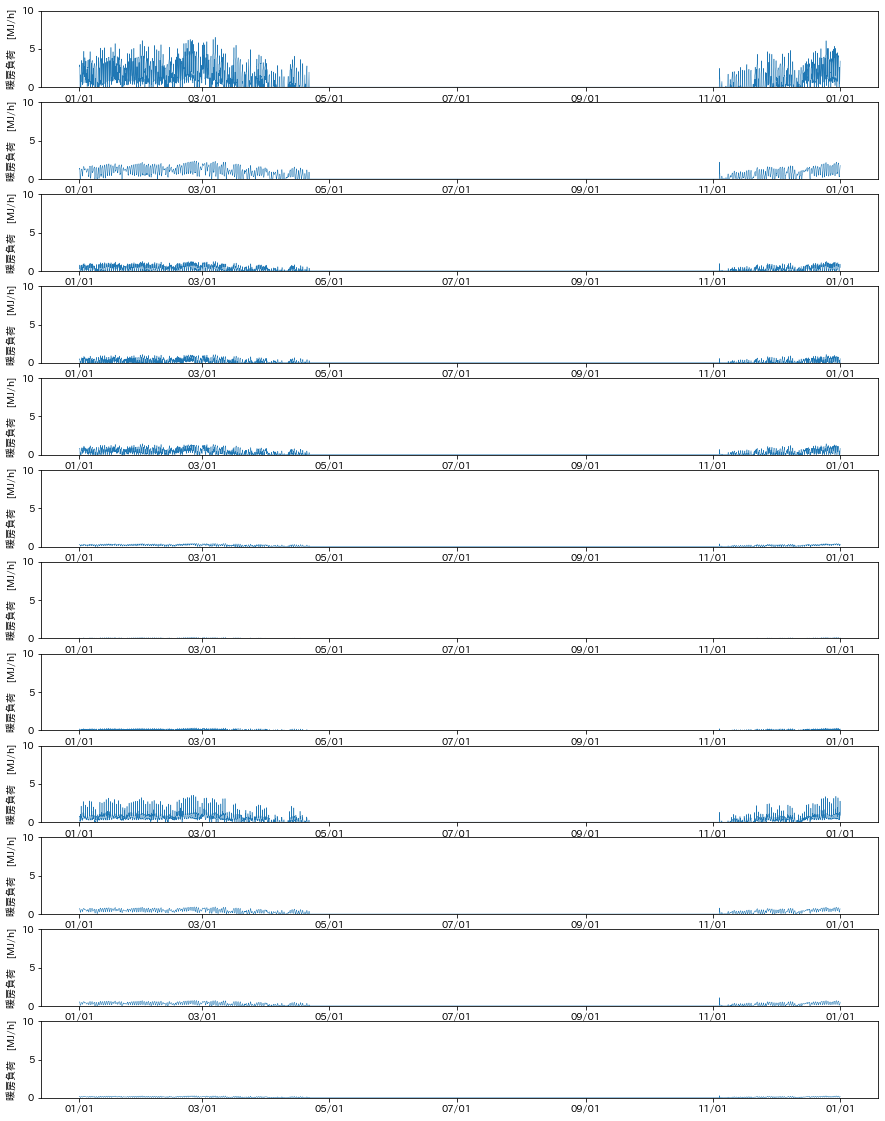

In [ ]:
# 暖房負荷の取得
print('【暖房負荷の取得】')
print('\t省エネルギー地域区分\t\t\t\t\t\t\t\t\tregion = {}'.format(region))
print('\t年間の日射地域区分(1-5)\t\t\t\t\t\t\t\t\tsol_region = {}'.format(sol_region))
print('\t床面積の合計 (m2)\t\t\t\t\t\t\t\t\tA_A = {}'.format(A_A))
print('\t主たる居室の床面積 (m2)\t\t\t\t\t\t\t\t\tA_MR = {}'.format(A_MR))
print('\tその他の居室の床面積 (m2)\t\t\t\t\t\t\t\tA_OR = {}'.format(A_OR))
print('\t当該住戸の熱損失係数 (W/m2K)\t\t\t\t\t\t\t\tQ = {}'.format(Q))
print('\t当該住戸の暖房期の日射取得係数 ((W/m2)/(W/m2))\t\t\t\t\t\tmu_H = {}'.format(mu_H))
print('\t当該住戸の冷房期の日射取得係数 ((W/m2)/(W/m2))\t\t\t\t\t\tmu_C = {}'.format(mu_C))
print('\t主たる居室における通風の利用における相当換気回数\t\t\t\t\tNV_MR = {}'.format(NV_MR))
print('\tその他の居室における通風の利用における相当換気回数\t\t\t\t\tNV_OR = {}'.format(NV_OR))
print('\t蓄熱の利用\t\t\t\t\t\t\t\t\t\tTS = {}'.format(TS))
print('\t当該住戸において、床下空間全体の面積に対する空気を供給する床下空間の面積の比 (-)\tr_A_ufvnt = {}'.format(r_A_ufvnt))
print('\t熱交換器型設備仕様辞書\t\t\t\t\t\t\t\t\tHEX = {}'.format(HEX))
print('\t床下空間が断熱空間内である場合はTrue\t\t\t\t\t\t\tunderfloor_insulation = {}'.format(underfloor_insulation))
print('\t暖房方式\t\t\t\t\t\t\t\t\t\tmode_H = {}'.format(mode_H))
print('\t冷房方式\t\t\t\t\t\t\t\t\t\tmode_C = {}'.format(mode_C))
print('\t主たる居室の暖房機器の仕様\t\t\t\t\t\t\t\tspec_MR = {}'.format(spec_MR))
print('\tその他の居室の暖房機器の仕様\t\t\t\t\t\t\t\tspec_OR = {}'.format(spec_OR))
print('\t主たる居室の運転方法 (連続運転|間歇運転)\t\t\t\t\t\tmode_MR = {}'.format(mode_MR))
print('\tその他の居室の運転方法 (連続運転|間歇運転)\t\t\t\t\t\tmode_OR = {}'.format(mode_OR))

L_H_d_t_i, _ = calc_heating_load(region, sol_region, A_A, A_MR, A_OR, Q, mu_H, mu_C, NV_MR, NV_OR, TS, r_A_ufvnt,
                                     HEX, underfloor_insulation, mode_H, mode_C, spec_MR, spec_OR, mode_MR, mode_OR, SHC)

plt.rcParams["font.size"] = 10
fig  =plt.figure(facecolor = 'w', figsize = (15, 20))

for ix in range(len(L_H_d_t_i)):
    ax = fig.add_subplot(len(L_H_d_t_i), 1, ix + 1)                                   
    ax.plot(pd.date_range('2019-01-01 01:00:00', '2020-01-01 00:00:00', freq='h'), L_H_d_t_i[ix], linewidth = 0.5)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax.set_ylabel('暖房負荷　[MJ/h]')                                                                           
    ax.set_ylim(0, 10)

plt.show()      

# 冷房負荷の取得（MJ/h）

【冷房負荷の取得】
	省エネルギー地域区分									region = 6
	床面積の合計 (m2)									A_A = 132.84
	主たる居室の床面積 (m2)									A_MR = 31.47
	その他の居室の床面積 (m2)								A_OR = 64.18
	当該住戸の熱損失係数 (W/m2K)								Q = 1.4474697380307135
	当該住戸の暖房期の日射取得係数 ((W/m2)/(W/m2))						mu_H = 0.03992687443541103
	当該住戸の冷房期の日射取得係数 ((W/m2)/(W/m2))						mu_C = 0.02169405600722674
	主たる居室における通風の利用における相当換気回数					NV_MR = 0
	その他の居室における通風の利用における相当換気回数					NV_OR = 0
	当該住戸において、床下空間全体の面積に対する空気を供給する床下空間の面積の比 (-)	r_A_ufvnt = 0.7089130102430821
	床下空間が断熱空間内である場合はTrue							underfloor_insulation = True
	冷房方式										mode_C = 住戸全体を連続的に冷房する方式
	暖房方式										mode_H = 住戸全体を連続的に暖房する方式
	主たる居室の運転方法 (連続運転|間歇運転)						mode_MR = None
	その他の居室の運転方法 (連続運転|間歇運転)						mode_OR = None
	蓄熱の利用										TS = False
	熱交換器型設備仕様辞書									HEX = None


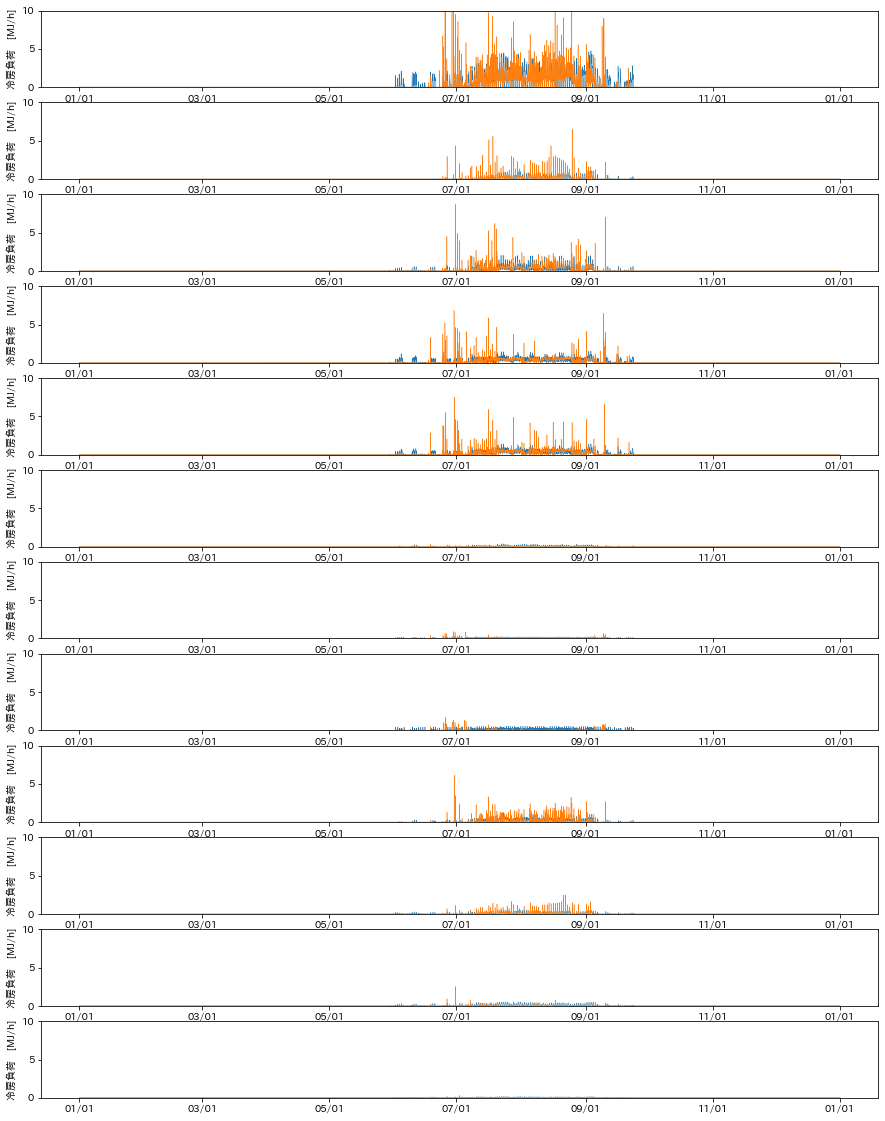

In [ ]:
# 冷房負荷の取得
print('【冷房負荷の取得】')
print('\t省エネルギー地域区分\t\t\t\t\t\t\t\t\tregion = {}'.format(region))
print('\t床面積の合計 (m2)\t\t\t\t\t\t\t\t\tA_A = {}'.format(A_A))
print('\t主たる居室の床面積 (m2)\t\t\t\t\t\t\t\t\tA_MR = {}'.format(A_MR))
print('\tその他の居室の床面積 (m2)\t\t\t\t\t\t\t\tA_OR = {}'.format(A_OR))
print('\t当該住戸の熱損失係数 (W/m2K)\t\t\t\t\t\t\t\tQ = {}'.format(Q))
print('\t当該住戸の暖房期の日射取得係数 ((W/m2)/(W/m2))\t\t\t\t\t\tmu_H = {}'.format(mu_H))
print('\t当該住戸の冷房期の日射取得係数 ((W/m2)/(W/m2))\t\t\t\t\t\tmu_C = {}'.format(mu_C))
print('\t主たる居室における通風の利用における相当換気回数\t\t\t\t\tNV_MR = {}'.format(NV_MR))
print('\tその他の居室における通風の利用における相当換気回数\t\t\t\t\tNV_OR = {}'.format(NV_OR))
print('\t当該住戸において、床下空間全体の面積に対する空気を供給する床下空間の面積の比 (-)\tr_A_ufvnt = {}'.format(r_A_ufvnt))
print('\t床下空間が断熱空間内である場合はTrue\t\t\t\t\t\t\tunderfloor_insulation = {}'.format(underfloor_insulation))
print('\t冷房方式\t\t\t\t\t\t\t\t\t\tmode_C = {}'.format(mode_C))
print('\t暖房方式\t\t\t\t\t\t\t\t\t\tmode_H = {}'.format(mode_H))
print('\t主たる居室の運転方法 (連続運転|間歇運転)\t\t\t\t\t\tmode_MR = {}'.format(mode_MR))
print('\tその他の居室の運転方法 (連続運転|間歇運転)\t\t\t\t\t\tmode_OR = {}'.format(mode_OR))
print('\t蓄熱の利用\t\t\t\t\t\t\t\t\t\tTS = {}'.format(TS))
print('\t熱交換器型設備仕様辞書\t\t\t\t\t\t\t\t\tHEX = {}'.format(HEX))

L_CS_d_t_i, L_CL_d_t_i = calc_cooling_load(region, A_A, A_MR, A_OR, Q, mu_H, mu_C, NV_MR, NV_OR, r_A_ufvnt,
                                               underfloor_insulation, mode_C, mode_H, mode_MR, mode_OR, TS, HEX)

plt.rcParams["font.size"] = 10
fig  =plt.figure(facecolor = 'w', figsize = (15, 20))

for ix in range(len(L_H_d_t_i)):
    ax = fig.add_subplot(len(L_H_d_t_i), 1, ix + 1)                                   
    ax.plot(pd.date_range('2019-01-01 01:00:00', '2020-01-01 00:00:00', freq='h'), L_CS_d_t_i[ix], linewidth = 0.5)
    ax.plot(pd.date_range('2019-01-01 01:00:00', '2020-01-01 00:00:00', freq='h'), L_CL_d_t_i[ix], linewidth = 0.5)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax.set_ylabel('冷房負荷　[MJ/h]')                                                                           
    ax.set_ylim(0, 10)

plt.show()      

# 暖房消費電力の計算（kWh/h）

【暖房消費電力の計算】
	床面積の合計 (m2)							A_A = 132.84
	主たる居室の床面積 (m2)							A_MR = 31.47
	その他の居室の床面積 (m2)						A_OR = 64.18
	外皮の部位の面積の合計 (m2)					A_env = 362.04
	当該住戸の暖房期の日射取得係数 ((W/m2)/(W/m2))				mu_H = 0.03992687443541103
	当該住戸の冷房期の日射取得係数 ((W/m2)/(W/m2))				mu_C = 0.02169405600722674
	当該住戸の熱損失係数 (W/m2K)						Q = 1.4474697380307135
	暖房方式								H_A = {'type': 'ダクト式セントラル空調機', 'duct_insulation': '全てもしくは一部が断熱区画外である', 'VAV': False, 'general_ventilation': True, 'EquipmentSpec': '入力しない'}
	暖房負荷								L_H_d_t_i
	冷房顕熱負荷								L_CS_d_t_i
	冷房潜熱負荷								L_CL_d_t_i
	省エネルギー地域区分							region = 6
	定格冷房能力 (W)							q_rtd_C = 2800
	定格暖房能力 (W)							q_rtd_H = 3300.1000000000004
	最大冷房能力 (W)							q_max_C = 3575.2599999999998
	最大暖房能力 (W)							q_max_H = 5877.685022
	定格暖房エネルギー消費効率						q_max_H = 4.875212
	定格暖房能力運転時の送風機の風量(m3/h)					V_fan_rtd_H = 1204.63014
	暖房時の送風機の設計風量(m3/h)						V_hs_dsgn_H = 951.6578106000001
	定格暖房能力運転時の送風機の消費電力(W)					P_fan_rtd_H = 181.317352
【calc_CRAC_Q_UT_A】


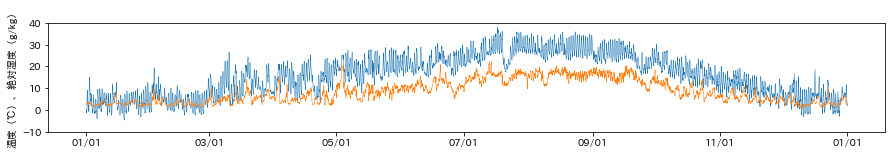

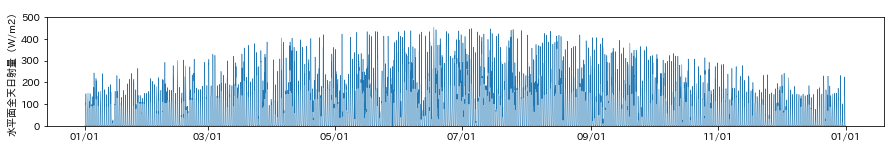

【calc_CRAC_E_E_H_d_t】


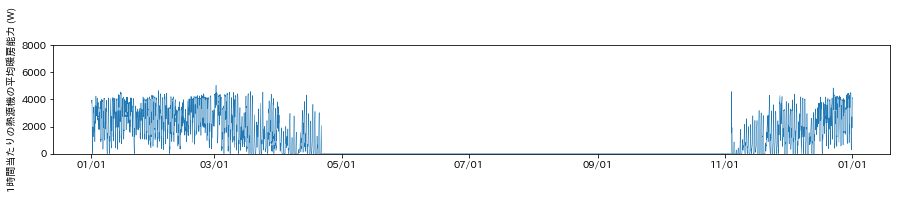

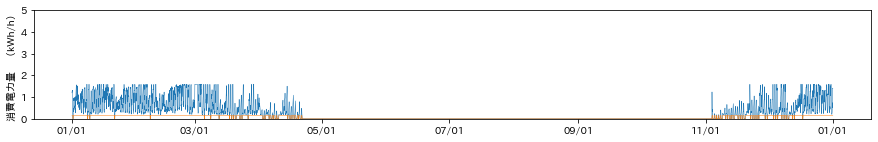

【暖房消費電力の計算結果】


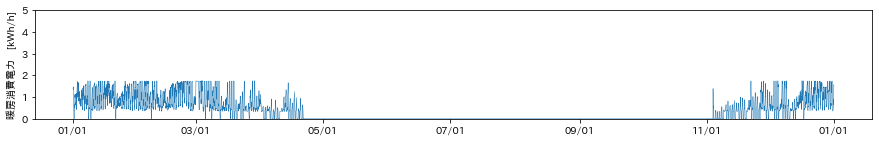

【暖房未処理負荷の計算結果】


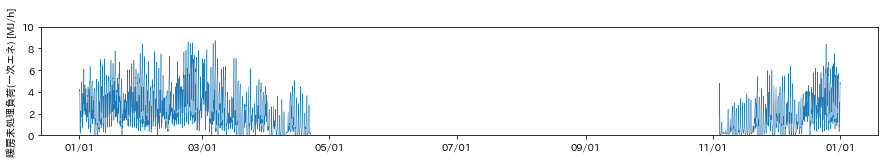

In [ ]:
print('【暖房消費電力の計算】')
print('\t床面積の合計 (m2)\t\t\t\t\t\t\tA_A = {}'.format(A_A))
print('\t主たる居室の床面積 (m2)\t\t\t\t\t\t\tA_MR = {}'.format(A_MR))
print('\tその他の居室の床面積 (m2)\t\t\t\t\t\tA_OR = {}'.format(A_OR))
print('\t外皮の部位の面積の合計 (m2)\t\t\t\t\tA_env = {}'.format(ENV['A_env']))
print('\t当該住戸の暖房期の日射取得係数 ((W/m2)/(W/m2))\t\t\t\tmu_H = {}'.format(mu_H))
print('\t当該住戸の冷房期の日射取得係数 ((W/m2)/(W/m2))\t\t\t\tmu_C = {}'.format(mu_C))
print('\t当該住戸の熱損失係数 (W/m2K)\t\t\t\t\t\tQ = {}'.format(Q))
print('\t暖房方式\t\t\t\t\t\t\t\tH_A = {}'.format(H_A))
print('\t暖房負荷\t\t\t\t\t\t\t\tL_H_d_t_i')
print('\t冷房顕熱負荷\t\t\t\t\t\t\t\tL_CS_d_t_i')
print('\t冷房潜熱負荷\t\t\t\t\t\t\t\tL_CL_d_t_i')
print('\t省エネルギー地域区分\t\t\t\t\t\t\tregion = {}'.format(region))
print('\t定格冷房能力 (W)\t\t\t\t\t\t\tq_rtd_C = {}'.format(q_rtd_C))
print('\t定格暖房能力 (W)\t\t\t\t\t\t\tq_rtd_H = {}'.format(q_rtd_H))
print('\t最大冷房能力 (W)\t\t\t\t\t\t\tq_max_C = {}'.format(q_max_C))
print('\t最大暖房能力 (W)\t\t\t\t\t\t\tq_max_H = {}'.format(q_max_H))
print('\t定格暖房エネルギー消費効率\t\t\t\t\t\tq_max_H = {}'.format(e_rtd_H))

V_fan_rtd_H = dc_spec.get_V_fan_rtd_H(q_rtd_H)
V_hs_dsgn_H = dc_spec.get_V_fan_dsgn_H(V_fan_rtd_H)
P_fan_rtd_H = dc_spec.get_P_fan_rtd_H(V_fan_rtd_H)

V_hs_dsgn_C = 0

print('\t定格暖房能力運転時の送風機の風量(m3/h)\t\t\t\t\tV_fan_rtd_H = {}'.format(V_fan_rtd_H))
print('\t暖房時の送風機の設計風量(m3/h)\t\t\t\t\t\tV_hs_dsgn_H = {}'.format(V_hs_dsgn_H))
print('\t定格暖房能力運転時の送風機の消費電力(W)\t\t\t\t\tP_fan_rtd_H = {}'.format(P_fan_rtd_H))

_, Q_UT_H_d_t_i, _, _, Theta_hs_out_d_t, Theta_hs_in_d_t, _, _, V_hs_supply_d_t, V_hs_vent_d_t, C_df_H_d_t\
 = calc_CRAC_Q_UT_A(A_A, A_MR, A_OR, ENV['A_env'], mu_H, mu_C,
                    q_rtd_C, q_rtd_H, q_max_C, q_max_H, V_hs_dsgn_H, V_hs_dsgn_C, Q, H_A['VAV'], H_A['general_ventilation'],
                    H_A['duct_insulation'], region, L_H_d_t_i, L_CS_d_t_i, L_CL_d_t_i)

E_E_H_d_t = calc_CRAC_E_E_H_d_t(Theta_hs_out_d_t = Theta_hs_out_d_t,
                                Theta_hs_in_d_t = Theta_hs_in_d_t,
                                V_hs_supply_d_t = V_hs_supply_d_t,
                                V_hs_vent_d_t = V_hs_vent_d_t,
                                C_df_H_d_t = C_df_H_d_t,
                                V_hs_dsgn_H = V_hs_dsgn_H,
                                P_fan_rtd_H = P_fan_rtd_H,
                                region = region,
                                q_rtd_C = q_rtd_C,
                                q_rtd_H = q_rtd_H,
                                e_rtd_H = e_rtd_H)

alpha_UT_H_A = get_alpha_UT_H_A(region)
Q_UT_H_A_d_t = np.sum(Q_UT_H_d_t_i, axis=0)
E_UT_H_d_t = Q_UT_H_A_d_t * alpha_UT_H_A

print('【暖房消費電力の計算結果】')
fig=plt.figure(facecolor = 'w', figsize = (15, 2))
ax = fig.add_subplot(1, 1, 1)                                   
ax.plot(pd.date_range('2019-01-01 01:00:00', '2020-01-01 00:00:00', freq='h'), E_E_H_d_t, linewidth = 0.5)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax.set_ylabel('暖房消費電力　[kWh/h]')                                                                           
ax.set_ylim(0, 5)
plt.show() 

print('【暖房未処理負荷の計算結果】')
fig=plt.figure(facecolor = 'w',figsize = (15, 2))
ax = fig.add_subplot(1, 1, 1)                                   
ax.plot(pd.date_range('2019-01-01 01:00:00', '2020-01-01 00:00:00', freq='h'), E_UT_H_d_t, linewidth = 0.5)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax.set_ylabel('暖房未処理負荷(一次エネ) [MJ/h]')                                                                           
ax.set_ylim(0, 10)
plt.show() 

# 冷房消費電力の計算（kWh/h）

	省エネルギー地域区分							region = 6
	床面積の合計 (m2)							A_A = 132.84
	主たる居室の床面積 (m2)							A_MR = 31.47
	その他の居室の床面積 (m2)						A_OR = 64.18
	A_env: 外皮の部位の面積の合計 (m2)					A_env = 362.04
	当該住戸の暖房期の日射取得係数 ((W/m2)/(W/m2))				mu_H = 0.03992687443541103
	当該住戸の冷房期の日射取得係数 ((W/m2)/(W/m2))				mu_C = 0.02169405600722674
	当該住戸の熱損失係数 (W/m2K)						Q = 1.4474697380307135
	冷房方式								C_A = {'type': 'ダクト式セントラル空調機', 'duct_insulation': '全てもしくは一部が断熱区画外である', 'VAV': False, 'general_ventilation': True, 'EquipmentSpec': '入力しない'}
	主たる居室の冷房機器							C_MR = None
	その他の居室の冷房機器							C_OR = None
	暖房負荷								L_H_d_t_i
	冷房顕熱負荷								L_CS_d_t_i
	冷房潜熱負荷								L_CL_d_t_i
	定格冷房能力 (W)							q_rtd_C = 2800
	定格暖房能力 (W)							q_rtd_H = 3300.1000000000004
	最大冷房能力 (W)							q_max_C = 3575.2599999999998
	最大暖房能力 (W)							q_max_H = 5877.685022
	定格暖房エネルギー消費効率						q_max_H = 4.875212
	定格冷房能力運転時の送風機の風量(m3/h)					V_fan_rtd_C = 1153.92
	冷房時の送風機の設計風量(m3/h)						V_hs_dsgn_C = 911.5968000000001
	定格冷房能力運転時の送風機の消費電力(W)					P_fan_rtd_C = 174.556


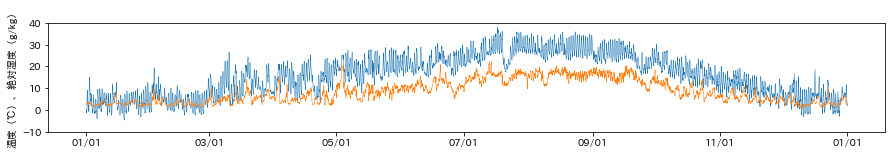

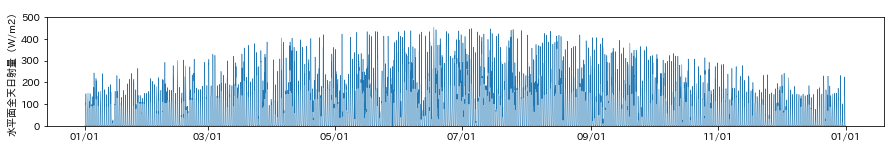

【get_CRAC_E_E_C_d_t】


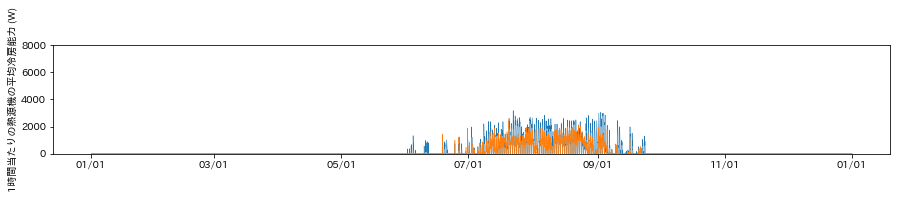

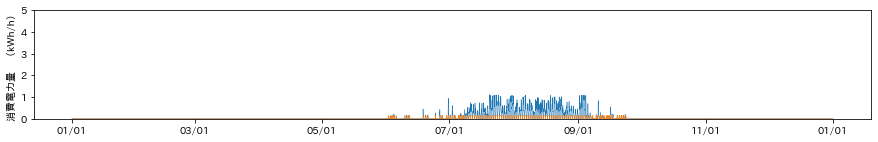

【冷房消費電力の計算結果】


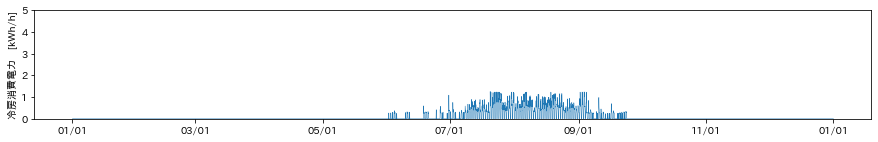

【冷房未処理負荷の計算結果】


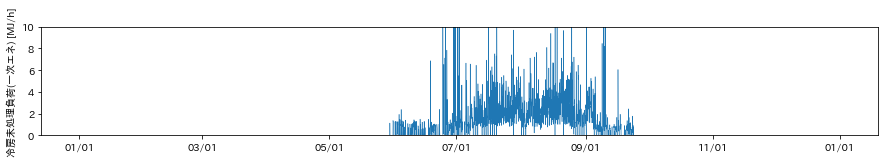

In [ ]:
print('\t省エネルギー地域区分\t\t\t\t\t\t\tregion = {}'.format(region))
print('\t床面積の合計 (m2)\t\t\t\t\t\t\tA_A = {}'.format(A_A))
print('\t主たる居室の床面積 (m2)\t\t\t\t\t\t\tA_MR = {}'.format(A_MR))
print('\tその他の居室の床面積 (m2)\t\t\t\t\t\tA_OR = {}'.format(A_OR))
print('\tA_env: 外皮の部位の面積の合計 (m2)\t\t\t\t\tA_env = {}'.format(ENV['A_env']))
print('\t当該住戸の暖房期の日射取得係数 ((W/m2)/(W/m2))\t\t\t\tmu_H = {}'.format(mu_H))
print('\t当該住戸の冷房期の日射取得係数 ((W/m2)/(W/m2))\t\t\t\tmu_C = {}'.format(mu_C))
print('\t当該住戸の熱損失係数 (W/m2K)\t\t\t\t\t\tQ = {}'.format(Q))
print('\t冷房方式\t\t\t\t\t\t\t\tC_A = {}'.format(C_A))
print('\t主たる居室の冷房機器\t\t\t\t\t\t\tC_MR = {}'.format(C_MR))
print('\tその他の居室の冷房機器\t\t\t\t\t\t\tC_OR = {}'.format(C_OR))
print('\t暖房負荷\t\t\t\t\t\t\t\tL_H_d_t_i')
print('\t冷房顕熱負荷\t\t\t\t\t\t\t\tL_CS_d_t_i')
print('\t冷房潜熱負荷\t\t\t\t\t\t\t\tL_CL_d_t_i')
print('\t定格冷房能力 (W)\t\t\t\t\t\t\tq_rtd_C = {}'.format(q_rtd_C))
print('\t定格暖房能力 (W)\t\t\t\t\t\t\tq_rtd_H = {}'.format(q_rtd_H))
print('\t最大冷房能力 (W)\t\t\t\t\t\t\tq_max_C = {}'.format(q_max_C))
print('\t最大暖房能力 (W)\t\t\t\t\t\t\tq_max_H = {}'.format(q_max_H))
print('\t定格暖房エネルギー消費効率\t\t\t\t\t\tq_max_H = {}'.format(e_rtd_H))

V_fan_rtd_C = dc_spec.get_V_fan_rtd_C(q_rtd_C)
V_hs_dsgn_C = dc_spec.get_V_fan_dsgn_C(V_fan_rtd_C)
P_fan_rtd_C = dc_spec.get_P_fan_rtd_C(V_fan_rtd_C)

V_hs_dsgn_H = 0

print('\t定格冷房能力運転時の送風機の風量(m3/h)\t\t\t\t\tV_fan_rtd_C = {}'.format(V_fan_rtd_C))
print('\t冷房時の送風機の設計風量(m3/h)\t\t\t\t\t\tV_hs_dsgn_C = {}'.format(V_hs_dsgn_C))
print('\t定格冷房能力運転時の送風機の消費電力(W)\t\t\t\t\tP_fan_rtd_C = {}'.format(P_fan_rtd_C))

E_UT_C_d_t, _, _, _, Theta_hs_out_d_t, Theta_hs_in_d_t, X_hs_out_d_t, X_hs_in_d_t, V_hs_supply_d_t, V_hs_vent_d_t, _\
= calc_CRAC_Q_UT_A(A_A, A_MR, A_OR, ENV['A_env'], mu_H, mu_C, 
                   q_rtd_C, q_rtd_H, q_max_C, q_max_H, V_hs_dsgn_H, V_hs_dsgn_C, Q, C_A['VAV'], C_A['general_ventilation'],
                   C_A['duct_insulation'], region, L_H_d_t_i, L_CS_d_t_i, L_CL_d_t_i)

E_E_C_d_t = get_CRAC_E_E_C_d_t(Theta_hs_out_d_t = Theta_hs_out_d_t,
                                 Theta_hs_in_d_t = Theta_hs_in_d_t,
                                 X_hs_out_d_t = X_hs_out_d_t,
                                 X_hs_in_d_t = X_hs_in_d_t,
                                 V_hs_supply_d_t = V_hs_supply_d_t,
                                 V_hs_vent_d_t = V_hs_vent_d_t,
                                 q_rtd_C = q_rtd_C,
                                 e_rtd_C = e_rtd_C,
                                 V_hs_dsgn_C = V_hs_dsgn_C,
                                 P_fan_rtd_C = P_fan_rtd_C,
                                 region = region)

print('【冷房消費電力の計算結果】')
fig=plt.figure(facecolor = 'w',figsize = (15, 2))
ax = fig.add_subplot(1, 1, 1)                                   
ax.plot(pd.date_range('2019-01-01 01:00:00', '2020-01-01 00:00:00', freq='h'), E_E_C_d_t, linewidth = 0.5)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax.set_ylabel('冷房消費電力　[kWh/h]')                                                                           
ax.set_ylim(0, 5)
plt.show() 

print('【冷房未処理負荷の計算結果】')
fig=plt.figure(facecolor = 'w',figsize = (15, 2))
ax = fig.add_subplot(1, 1, 1)                                   
ax.plot(pd.date_range('2019-01-01 01:00:00', '2020-01-01 00:00:00', freq='h'), E_UT_C_d_t, linewidth = 0.5)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax.set_ylabel('冷房未処理負荷(一次エネ) [MJ/h]')                                                                           
ax.set_ylim(0, 10)
plt.show() 

# 計算結果のまとめ

In [ ]:
# 電気の量 1kWh を熱量に換算する係数
f_prim = get_f_prim()

# 1 時間当たりの暖房設備の設計一次エネルギー消費量（MJ/h）
E_H_d_t = E_E_H_d_t * f_prim / 1000 + E_UT_H_d_t

# 1 時間当たりの冷房設備の設計一次エネルギー消費量（MJ/h）
E_C_d_t = E_E_C_d_t * f_prim / 1000 + E_UT_C_d_t

# 1 年当たりの暖房設備の設計一次エネルギー消費量（MJ/年）
E_H = np.sum(E_H_d_t)

# 1 年当たりの冷房設備の設計一次エネルギー消費量（MJ/年）
E_C = np.sum(E_C_d_t)

print({'E_H': E_H, 'E_C': E_C})

{'E_H': 39039.629637526545, 'E_C': 10501.826876141822}


{'E_H': 38986.65275929407, 'E_C': 14596.270280805114}

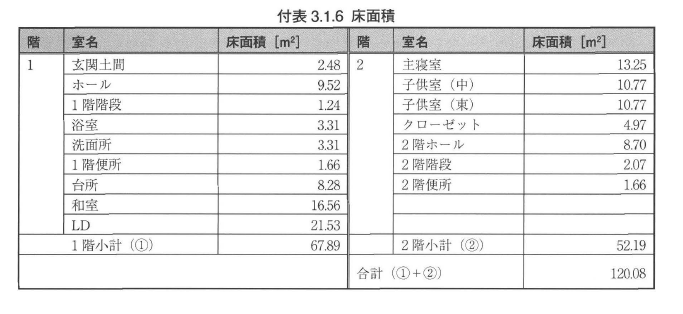